In [162]:
# 载入算法库
from utils import *
from SS_origin import *
from CIRR import *
from FEAST import *
from Block_SS import *

# 必要python库
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import warnings

# 禁用所有警告
warnings.filterwarnings("ignore")

# Example 1

In [163]:
# 定义矩阵
diag = np.linspace(0.99, 0, 100)
diag_one = np.ones(99)*0.01
A = np.diag(diag) + np.diag(diag_one, k=1)
B = np.zeros((100, 100))
B[80:, 80:] = np.eye(20)

## 特征值分布

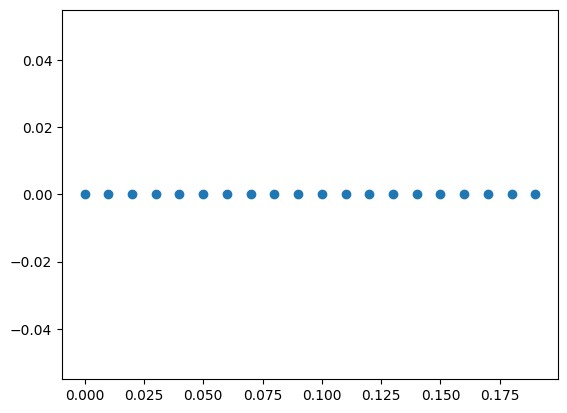

In [164]:
# 计算精确特征值和特征向量
real_eigvals, real_vectors = linalg.eig(A, B)
plt.scatter(np.real(real_eigvals), np.imag(real_eigvals))


### SS

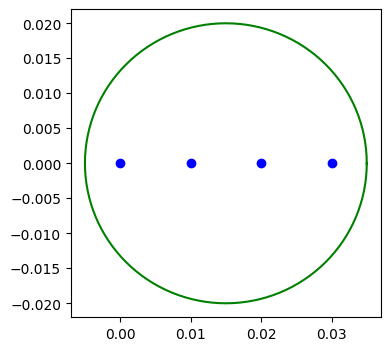

In [165]:
# 区域
gamma = 0.015
r = 0.02

# 采样点
N = 128
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)
filter = np.abs(real_eigvals-gamma) < r

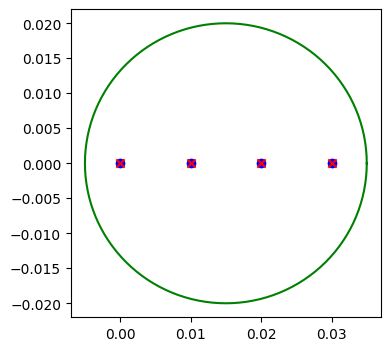

In [166]:
# 矩的数量
M = m+1
np.random.seed(123)
# 探测向量(矩阵)
nev = 1
n = A.shape[0]
u = np.random.rand(n)
V = np.random.rand(n, nev)

## ss
ss_vals, ss_vector = ss_origin(A, B, V, gamma, r, N, M, u)

# 绘制结果
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=ss_vals)

### CIRR

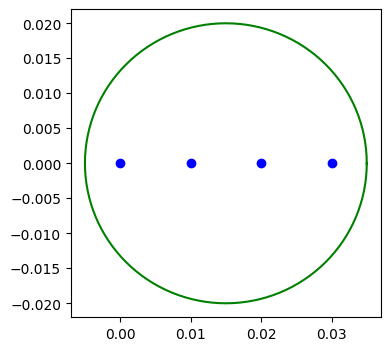

In [167]:
# 采样点
N = 128
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)

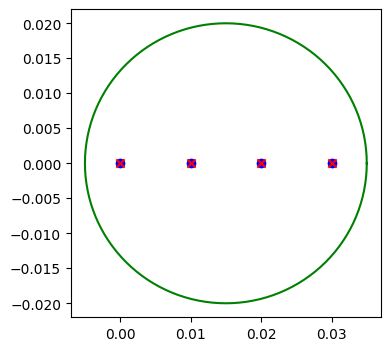

In [168]:
# 矩的数量(M>2)
M = int(np.ceil(m*1.5))
np.random.seed(123)
# 探测向量(矩阵)
nev = 1
n = A.shape[0]
u = np.random.rand(n)
V = np.random.rand(n, nev)
CIRR_vals, CIRR_vectors = CIRR(A, B, V, gamma, r, N, M)
# 绘制结果
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=CIRR_vals)

### FEAST

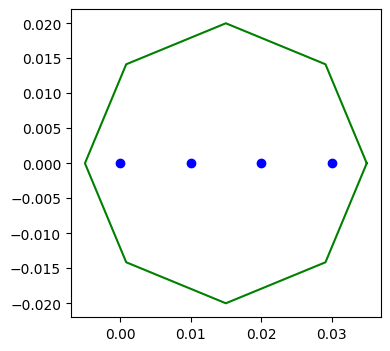

In [169]:
# 采样点
N = 8
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)


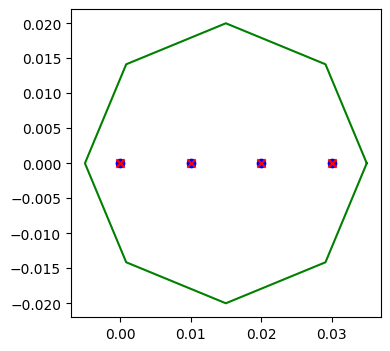

In [170]:
np.random.seed(123)
# 探测向量(矩阵)
nev = int(np.ceil(2*m))
n = A.shape[0]
V = np.random.rand(n, nev)
feast_vals, feast_vectors, res_his = FEAST(A, B, V, gamma, r, N, tol=1e-16, max_iter=12)
# 绘制结果
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=feast_vals)

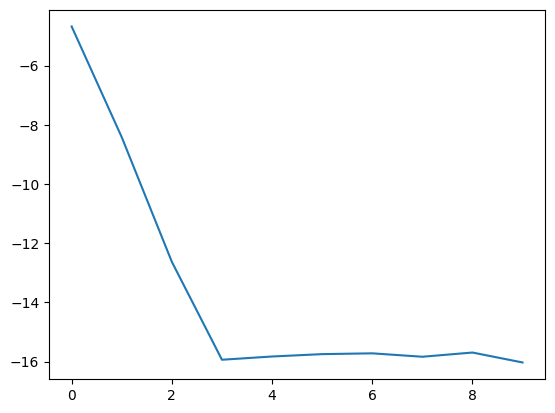

In [171]:
plt.plot(np.log10(res_his))

In [172]:
# 统计误差
ss = list(zip(ss_vals, relres_dense(A, B, ss_vals, ss_vector)))
cirr = list(zip(CIRR_vals, relres_dense(A, B, CIRR_vals, CIRR_vectors)))
feast = list(zip(feast_vals, relres_dense(A, B, feast_vals, feast_vectors)))
X = [ss, cirr, feast]
r = stat_error(X, A, B, real_eigvals, real_vectors, filter)
r

,eigenvals,SS,CIRR,FEAST,LAPACK
0,3.00e-02,1.18e-10,1.96e-16,6.68e-17,4.24e-19
1,2.00e-02,2.98e-10,3.04e-16,9.30e-17,9.64e-19
2,1.00e-02,6.63e-10,3.91e-16,7.93e-17,9.07e-19
3,0.00e+00,1.12e-09,2.54e-16,3.34e-18,5.15e-19


# Example 2

In [173]:
A = mmread(os.path.join("data", 'mhda416.mtx')).toarray()
B = mmread(os.path.join("data", 'mhdb416.mtx')).toarray()

# 2.1

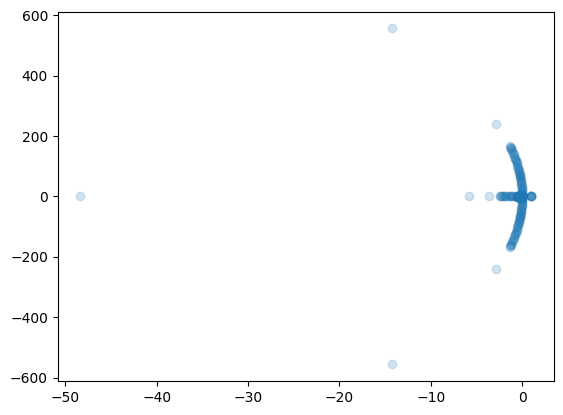

In [260]:
# 计算准确特征值
real_eigvals, real_vectors = linalg.eig(A, B, right=True)
plt.scatter(np.real(real_eigvals), np.imag(real_eigvals), alpha=0.2)
# 区域
gamma = -0.2+0.6*1j
r = 0.05
filter = np.abs(real_eigvals-gamma) < r

### SS

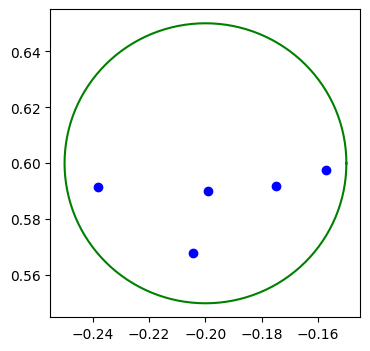

In [175]:
# 采样点数
N = 128
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)


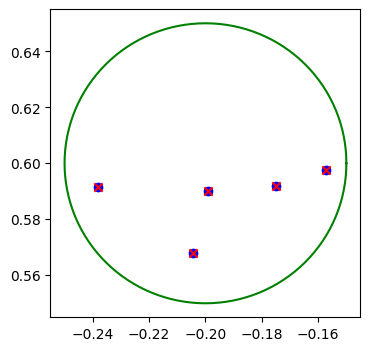

In [176]:
np.random.seed(123)
n = A.shape[0]
u = np.random.rand(n)
V = np.random.rand(n).reshape(-1, 1)
ss_vals, ss_vector = ss_origin(A, B, B@V, gamma, r, N, m, u)
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=ss_vals)

In [177]:
print(f'ss算法的相对残差{relres_dense(A, B, ss_vals, ss_vector)}')
filter = np.abs(real_eigvals-gamma) < r
print(f'baseline的相对残差{relres_dense(A, B, real_eigvals[filter], real_vectors[:, filter])}')

ss算法的相对残差[3.64218490e-13 1.77519867e-13 2.84279846e-13 8.44813935e-14
 1.35541981e-14]
baseline的相对残差[2.34032690e-17 2.26495897e-17 2.56325375e-17 2.15267817e-17
 2.10267893e-17]


### CIRR

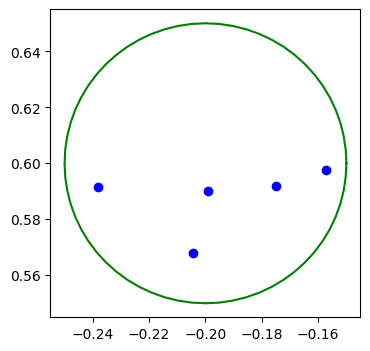

In [178]:
N = 64
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)


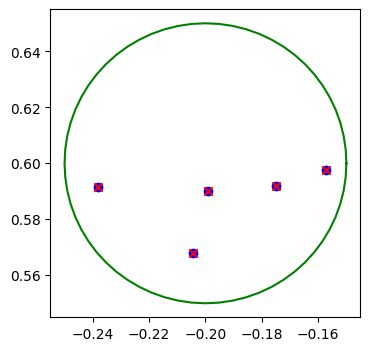

In [179]:
M = int(np.ceil(m*1.5))
np.random.seed(123)
n = A.shape[0]
u = np.random.rand(n)
V = np.random.rand(n).reshape(-1, 1)
CIRR_vals, CIRR_vector = CIRR(A, B, B@V, gamma, r, N, M)
# 剔除不达标的特征值
idx = np.argsort(relres_dense(A, B, CIRR_vals, CIRR_vector))[:m]
CIRR_vals = CIRR_vals[idx]
CIRR_vector = CIRR_vector[:, idx]
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=CIRR_vals)

### FEAST

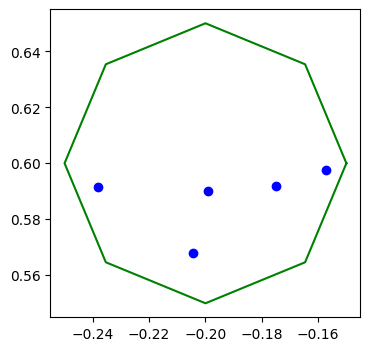

In [180]:
N = 8
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)


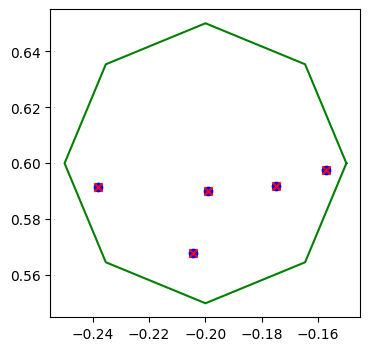

In [181]:
np.random.seed(123)
n = A.shape[0]
nev = int(np.ceil(m*2))
V = np.random.rand(n, nev)
feast_vals, feast_vector, res_his = FEAST(A, B, V, gamma, r, N, tol=1e-18, max_iter=10)
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=feast_vals)

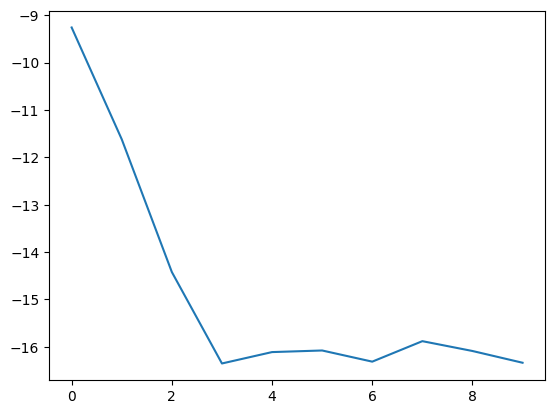

In [182]:
plt.plot(np.log10(res_his))

### 统计结果

In [183]:
# 统计误差
ss = list(zip(ss_vals, relres_dense(A, B, ss_vals, ss_vector)))
cirr = list(zip(CIRR_vals, relres_dense(A, B, CIRR_vals, CIRR_vector)))
feast = list(zip(feast_vals, relres_dense(A, B, feast_vals, feast_vector)))
X = [ss, cirr, feast]
r = stat_error(X, A, B, real_eigvals, real_vectors, filter)
r

,eigenvals,SS,CIRR,FEAST,LAPACK
0,-2.38e-01,3.64e-13,5.74e-17,3.18e-17,2.34e-17
1,-1.99e-01,2.84e-13,1.39e-16,4.61e-17,2.26e-17
2,-2.05e-01,1.78e-13,3.81e-17,4.49e-17,2.56e-17
3,-1.75e-01,8.45e-14,1.68e-16,3.86e-17,2.15e-17
4,-1.57e-01,1.36e-14,5.11e-17,3.01e-17,2.10e-17


# Example 2.2

In [184]:
# 区域
gamma = 0
r = 0.00002
filter = np.abs(real_eigvals-gamma) < r


### SS

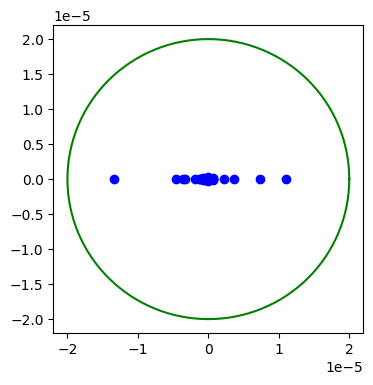

In [185]:
N = 128
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)


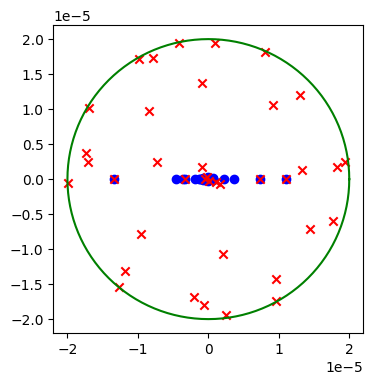

In [186]:
np.random.seed(123)
n = A.shape[0]
nev = 1
u = np.random.rand(n)
V = np.random.rand(n,1)
M = m
ss_vals, ss_vector = CIRR(A, B, B@V, gamma, r, N, M)
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=ss_vals)

In [187]:
relres_dense(A, B, ss_vals, ss_vector), len(ss_vals)

(array([3.53498058e-12, 2.39843917e-12, 2.47609764e-12, 5.14408611e-12,
        6.83986001e-12, 4.54849350e-12, 2.75794591e-12, 2.27235375e-12,
        7.70584160e-16, 3.59296885e-12, 3.06009783e-12, 2.24270322e-12,
        2.19941791e-12, 4.97030170e-12, 3.78172344e-12, 1.30122511e-12,
        1.10328698e-12, 2.58086110e-12, 6.92328962e-15, 3.30139875e-12,
        1.25518664e-13, 3.40909284e-12, 6.91294615e-12, 3.78327511e-12,
        2.99444922e-12, 4.21207642e-12, 4.26764229e-12, 5.59272543e-12,
        1.92029279e-13, 2.23116906e-11, 2.57669207e-11, 2.36409824e-11,
        1.60151860e-11, 2.23077289e-11, 2.00197125e-11, 3.77471081e-12,
        4.40226521e-12, 6.78637932e-12]),
 38)

In [235]:
ss_info = [len(ss_vals), np.min(relres_dense(A, B, ss_vals, ss_vector)), np.max(relres_dense(A, B, ss_vals, ss_vector)),\
           np.mean(relres_dense(A, B, ss_vals, ss_vector)), np.median(relres_dense(A, B, ss_vals, ss_vector))]
ss_info

[38,
 7.705841598520216e-16,
 2.5766920737769653e-11,
 6.1744544047310126e-12,
 3.68383983430758e-12]

### CIRR

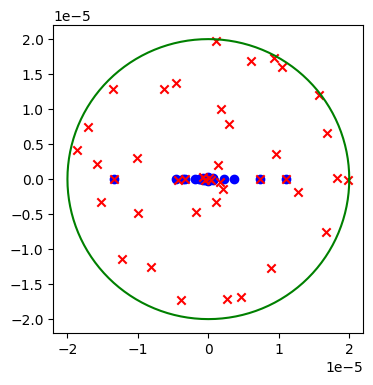

In [189]:
# 矩的数量(M>2)
M = int(np.ceil(m*1.5))
np.random.seed(123)
# 探测向量(矩阵)
nev = 1
n = A.shape[0]
u = np.random.rand(n)
V = np.random.rand(n, nev)
CIRR_vals, CIRR_vectors = CIRR(A, B, V, gamma, r, N, M)
# 绘制结果
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=CIRR_vals)

In [190]:
relres_dense(A, B, CIRR_vals, CIRR_vectors), len(CIRR_vals)

(array([2.10107727e-12, 1.66791538e-12, 2.65366506e-12, 2.62658426e-12,
        3.11912980e-12, 9.36338842e-13, 1.43752162e-12, 1.49711802e-12,
        2.07298631e-12, 1.79753607e-12, 1.61039455e-12, 3.91084749e-12,
        3.26900454e-12, 6.81660985e-13, 7.66864793e-13, 2.32501793e-12,
        7.14065463e-13, 1.06979933e-12, 1.44254514e-12, 1.29395820e-15,
        1.72193590e-12, 2.20393059e-15, 3.54643008e-12, 3.77510278e-12,
        3.47666633e-12, 1.61534002e-12, 2.39776765e-12, 4.41312933e-12,
        3.04669566e-14, 4.44840846e-12, 4.18997243e-12, 6.56850267e-14,
        1.63929061e-12, 3.37874304e-12, 2.54083411e-12, 4.89311393e-12,
        2.03955087e-12, 8.13120783e-12, 1.00108635e-11, 6.88486524e-12,
        8.66011030e-12, 6.25968024e-12]),
 42)

In [234]:
CIRR_info = [len(CIRR_vals), np.min(relres_dense(A, B, CIRR_vals, CIRR_vectors)), np.max(relres_dense(A, B, CIRR_vals, CIRR_vectors)),\
             np.mean(relres_dense(A, B, CIRR_vals, CIRR_vectors)), np.median(relres_dense(A, B, CIRR_vals, CIRR_vectors))]
CIRR_info

[42,
 1.2939582011659673e-15,
 1.0010863506994132e-11,
 2.852922270678485e-12,
 2.2130475973447425e-12]

### FEAST

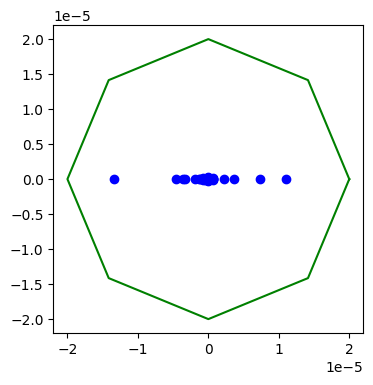

In [192]:
N = 8
z, w = points_weights(gamma, r, N)
m = plot_field(real_eigvals, z=z, r=r, gamma=gamma)

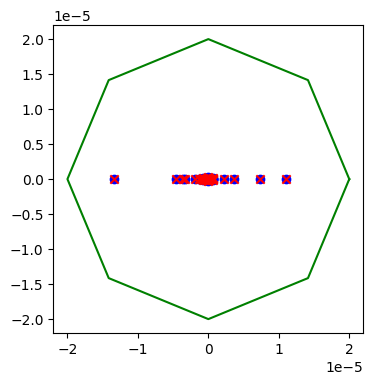

In [215]:
nev = int(np.ceil(m*1.5))
np.random.seed(123)
n = A.shape[0]
V = np.random.rand(n, nev)
feast_vals, feast_vectors, res_his = FEAST(A, B, V, gamma, r, N, tol=1e-15, max_iter=20)
plot_field(real_eigvals, z=z, r=r, gamma=gamma, calculated_value=feast_vals)

In [217]:
relres_dense(A, B, feast_vals, feast_vectors), len(feast_vals)

(array([8.14075134e-18, 9.62610530e-18, 6.23834833e-18, 5.96185006e-18,
        1.87867962e-17, 7.39125841e-18, 1.40388406e-17, 3.38767675e-17,
        1.43382811e-17, 1.49770250e-17, 1.42826511e-17, 3.66576647e-17,
        4.10460978e-17, 1.49651294e-17, 2.55921678e-17, 1.48126830e-17,
        7.89909978e-18, 4.42001815e-17, 2.30804289e-17, 2.52747488e-17,
        1.89653436e-17, 5.90801422e-18, 1.04637077e-17, 4.38272607e-18,
        4.42796290e-18, 1.03155261e-16, 1.90986495e-17, 1.63261203e-17,
        2.05995457e-17, 3.04454409e-18, 2.30865538e-18, 1.04326241e-17,
        1.03594010e-17, 2.01119906e-17, 3.37371324e-18, 1.65570535e-17,
        4.18985126e-18, 1.15189489e-17, 5.32432935e-18, 3.73026287e-18,
        1.17330817e-16, 4.28254528e-18, 3.73705770e-18, 3.70693583e-18,
        4.15081537e-18, 3.21984930e-18, 1.14368561e-17, 1.08458943e-17,
        5.57967994e-18, 6.89324044e-18, 7.01898528e-18, 2.74392941e-18,
        2.26885053e-17, 4.63346932e-17, 3.83454986e-18, 1.219293

In [233]:
FEAST_info = [len(feast_vals), np.min(relres_dense(A, B, feast_vals, feast_vectors)), np.max(relres_dense(A, B, feast_vals, feast_vectors)), \
              np.mean(relres_dense(A, B, feast_vals, feast_vectors)), np.median(relres_dense(A, B, feast_vals, feast_vectors))]
FEAST_info

[98,
 2.3086553794534518e-18,
 1.1733081664430197e-16,
 1.2454937469349599e-17,
 6.3593188941172586e-18]

In [227]:
relres_dense(A, B, real_eigvals[filter], real_vectors[:,filter]), len(real_eigvals[filter])

(array([7.02522188e-17, 7.35571097e-17, 6.53484178e-17, 4.32731552e-17,
        1.23331985e-16, 4.44697196e-17, 8.80868129e-17, 4.83341175e-17,
        1.02223468e-16, 3.91651673e-17, 5.89963625e-17, 6.92142849e-17,
        6.92142849e-17, 3.69840560e-17, 5.41341860e-17, 5.41341860e-17,
        5.40050557e-17, 4.47080187e-17, 2.55108243e-17, 6.91036072e-17,
        6.91036072e-17, 1.12593160e-16, 5.67190805e-17, 3.11534867e-17,
        9.47781539e-17, 9.47781539e-17, 9.92421516e-17, 6.89438974e-17,
        6.89438974e-17, 9.78504672e-17, 9.78504672e-17, 6.22084166e-17,
        4.67838927e-17, 5.49930195e-17, 9.50468849e-17, 9.50468849e-17,
        5.78947871e-17, 5.78947871e-17, 9.66885667e-17, 4.72266478e-17,
        9.23784309e-17, 9.23784309e-17, 9.63672653e-17, 9.63672653e-17,
        9.70875807e-17, 7.54847977e-17, 7.54847977e-17, 9.16206321e-17,
        9.16206321e-17, 4.44951645e-17, 9.41873996e-17, 3.99393266e-17,
        9.40937189e-17, 4.69315868e-17, 9.29505126e-17, 9.295051

In [240]:
LAPACK_info = [len(real_eigvals[filter]), np.min(relres_dense(A, B, real_eigvals[filter], real_vectors[:,filter])), np.max(relres_dense(A, B, real_eigvals[filter], real_vectors[:,filter])), \
               np.mean(relres_dense(A, B, real_eigvals[filter], real_vectors[:,filter])), np.median(relres_dense(A, B, real_eigvals[filter], real_vectors[:,filter]))]
LAPACK_info[1:]

[2.5510824261107356e-17,
 1.2333198543657472e-16,
 7.863161016760421e-17,
 8.876621063335655e-17]

In [259]:
# 统计结果
columns = ['num', 'min', 'max', 'mean', 'median']
info = [ss_info, CIRR_info, FEAST_info, LAPACK_info]
def to_sci(x):
    return f"{x:.2e}"
df = pd.DataFrame(info, columns=columns)
# 对除第一列以外的所有列应用该函数
for col in df.columns[1:]:
    df[col] = df[col].apply(to_sci)
df.insert(0, 'method', ['SS', 'CIRR', 'FEAST', 'LAPACK'])
df

,method,num,min,max,mean,median
0,SS,38,7.71e-16,2.58e-11,6.17e-12,3.68e-12
1,CIRR,42,1.29e-15,1.00e-11,2.85e-12,2.21e-12
2,FEAST,98,2.31e-18,1.17e-16,1.25e-17,6.36e-18
3,LAPACK,98,2.55e-17,1.23e-16,7.86e-17,8.88e-17
